**Brian Blaylock**  
**January 10, 2019**

# HRRR Terrain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_variable
from BB_cmap.landuse_colormap import LU_MODIS21
from BB_cmap.FLAME_cmap import cm_ros
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap

In [211]:
H = get_hrrr_variable(datetime(2019,1,1), 'HGT:surface')
H_land = get_hrrr_variable(datetime(2019,1,1), 'LAND:surface')


 >> Dowloading tempfile: ./temp_hrrr_2019010100_f00_HGT.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  58:30896245:d=2019010100:HGT:surface:anl:
 >> Byte Range: 30896245 33131021
  Run Date: 2019-01-01 00:00 UTC F00
Valid Date: 2019-01-01 00:00 UTC

 >> Dowloading tempfile: ./temp_hrrr_2019010100_f00_LAN.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  143:101738055:d=2019010100:LAND:surface:anl:
 >> Byte Range: 101738055 101788530
  Run Date: 2019-01-01 00:00 UTC F00
Valid Date: 2019-01-01 00:00 UTC


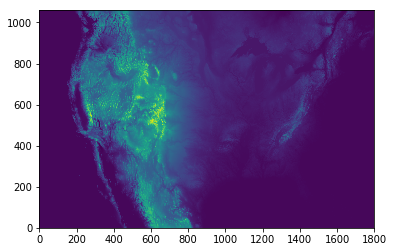

In [6]:
plt.pcolormesh(H['value'])

In [51]:
ter_lon = np.percentile(H['value'], [0,5, 25, 50, 75, 95, 100], axis=0)
mean_lon = np.mean(H['lon'], axis=0)

In [52]:
ter_lon[0]

array([-0.03599548, -0.03599548, -0.03599548, ..., -0.03599548,
       -0.03599548, -0.03599548])

Text(0.5,0,'Approximate Longitude')

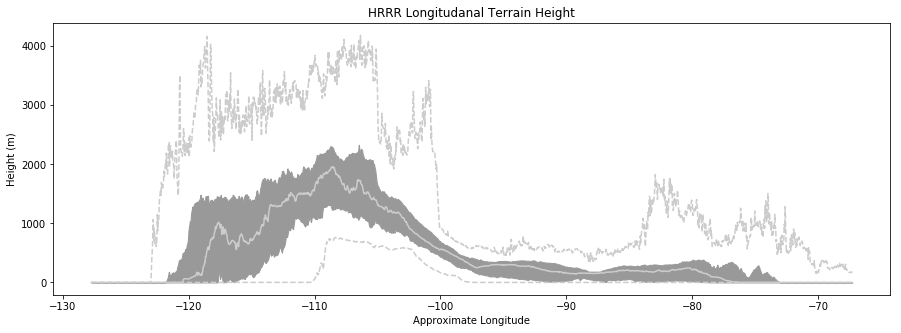

In [59]:
light_grey = [.8,.8,.8]
grey = [.6,.6,.6]

plt.figure(figsize=[15,5])

plt.fill_between(mean_lon, ter_lon[2], ter_lon[4], color=grey)
#plt.plot(mean_lon, ter_lon[0], linestyle='--', color=light_grey)
plt.plot(mean_lon, ter_lon[1], linestyle='--', color=light_grey)
plt.plot(mean_lon, ter_lon[3], color=light_grey)
#plt.plot(mean_lon, ter_lon[-2], linestyle='--', color=light_grey)
plt.plot(mean_lon, ter_lon[-1], linestyle='--', color=light_grey)

plt.title('HRRR Longitudanal Terrain Height')
plt.ylabel('Height (m)')
plt.xlabel('Approximate Longitude')

## Terrain Plot

In [7]:
m = draw_HRRR_map()

In [222]:
# Set water points as a low value for terrain colormap to display correctly.
H['value'][H_land['value']==0] = -4500

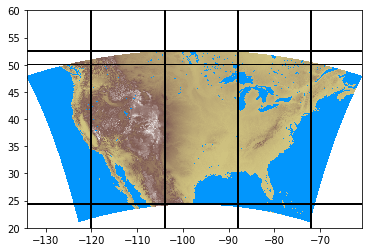

In [119]:
c = .3
plt.pcolormesh(H['lon'], H['lat'], H['value'], vmin=-6000, cmap='terrain');
plt.axvline(-120, linewidth=2, color='k');
plt.axvline(-104, linewidth=2, color='k');
plt.axvline(-88, linewidth=2, color='k');
plt.axvline(-72, linewidth=2, color='k');
plt.axhline(H['lat'][0].max(), color='k', linewidth=2);
plt.axhline(H['lat'][-1].max(), color='k', linewidth=2);
plt.axhline(50.2, color='k', linewidth=1);
plt.ylim([20,60]);

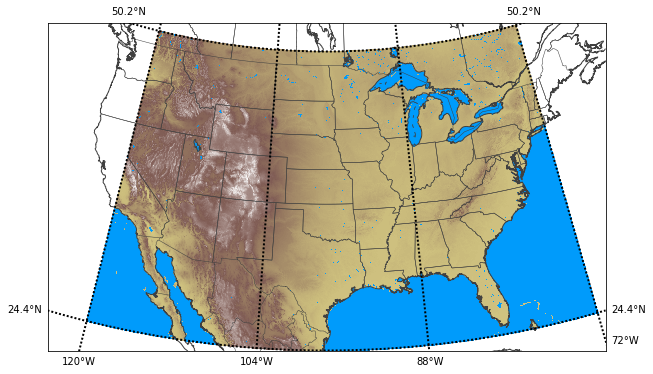

In [228]:
plt.figure(figsize=[10,8])
c = .25
masked = np.ma.array(H['value'], mask=H['lon']<-120)
masked = np.ma.array(masked, mask=H['lon']>-72)
masked = np.ma.array(masked, mask=H['lat']<H['lat'][0].max())
masked = np.ma.array(masked, mask=H['lat']>50.2)

m.pcolormesh(H['lon'], H['lat'], masked, vmin=-6100, latlon=True, cmap='terrain');
#m.contour(H['lon'], H['lat'], masked2, levels=[1500], latlon=True, colors='k');
m.drawstates(color=[c,c,c]);
m.drawcountries(color=[c,c,c])
m.drawcoastlines(color=[c,c,c])
m.drawmeridians(np.array([-104-16, -104, -104+16, -104+16+16]), labels=[1,1,0,1], fontsize=10, linewidth=2);
m.drawparallels(np.array([24.4, 50.2]), labels=[1,1,1,1], fontsize=10, linewidth=2);

## Plot a segment
We can't use contour on masked arrays becuase it doesn't make closed contours (can't use nan values either). But we can set everything outside the segment to zero before drawing the contour!

In [218]:
H['value'].max()

4183.7764

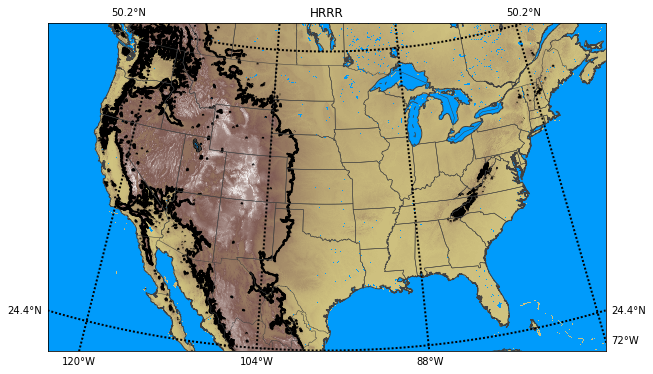

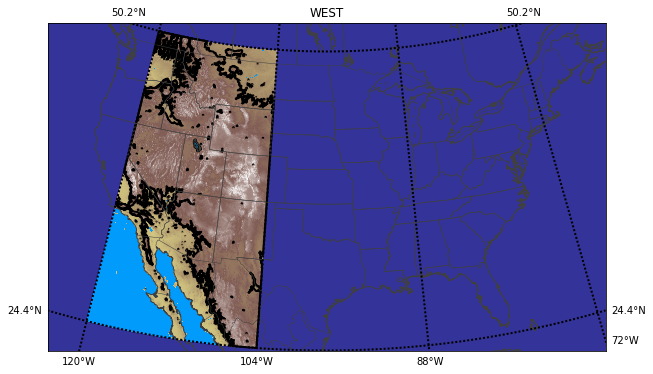

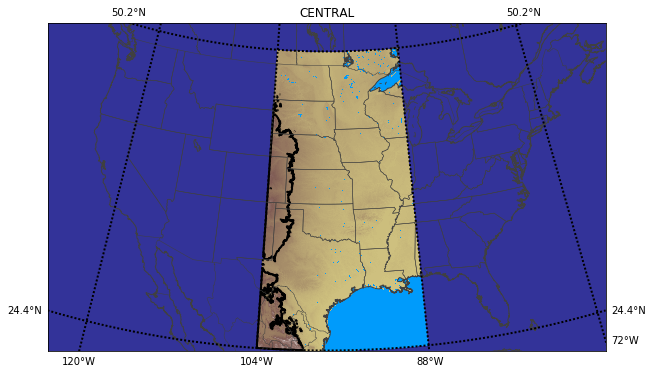

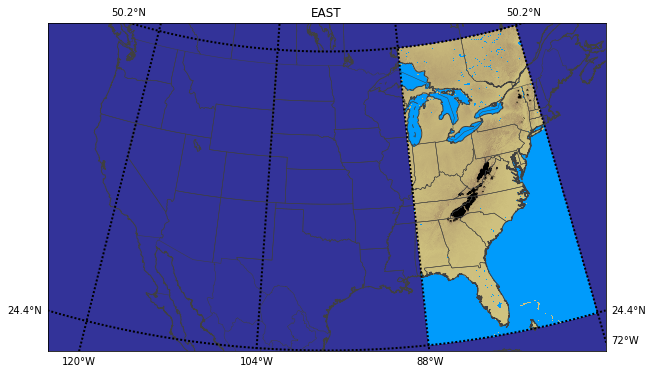

In [232]:
SEGMENTS = {'HRRR':[H['lon'].min(), H['lon'].max(), H['lat'].min(), H['lat'].max()],
            'west':[-120, -104, 24.4, 50.2],
            'central': [-104, -88, 24.4, 50.2],
            'east':[-88, -72, 24.4, 50.2]}

for bounds in SEGMENTS.keys():
    # Find segment area
    w, e, s, n = SEGMENTS[bounds]
    sectionA = H['lon']>=w
    sectionB = H['lon']<e
    sectionD = H['lat']>=s
    sectionC = H['lat']<n

    segment = sectionA*sectionB*sectionC*sectionD

    new_H = H['value'].copy()
    new_H[segment==False] = -6100

    plt.figure(figsize=[10,8])
    plt.title(bounds.upper())
    m.pcolormesh(H['lon'], H['lat'], new_H, vmin=-6100, vmax=4183, latlon=True, cmap='terrain');
    m.contour(H['lon'], H['lat'], new_H, levels=[1000], latlon=True, colors='k', linewidths=2);
    m.drawstates(color=[c,c,c]);
    m.drawcountries(color=[c,c,c])
    m.drawcoastlines(color=[c,c,c])
    m.drawmeridians(np.array([-104-16, -104, -104+16, -104+16+16]), labels=[1,1,0,1], fontsize=10, linewidth=2);
    m.drawparallels(np.array([24.4, 50.2]), labels=[1,1,1,1], fontsize=10, linewidth=2);

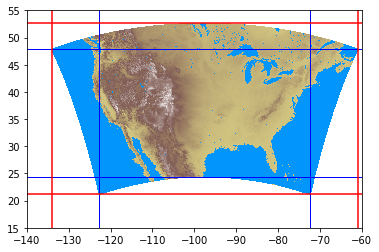

In [265]:
c = .3
plt.pcolormesh(H['lon'], H['lat'], H['value'], vmin=-6000, cmap='terrain');
#plt.axvline(-120, linewidth=.5, color='k');
#plt.axvline(-104, linewidth=.5, color='k');
#plt.axvline(-88, linewidth=.5, color='k');
#plt.axvline(-72, linewidth=.5, color='k');
#plt.axhline(50.2, color='k', linewidth=.5);

plt.axhline(H['lat'][0].max(), linewidth=1, color='b');
plt.axhline(H['lat'][-1].min(), linewidth=1, color='b');
plt.axvline(H['lon'][:,0].max(), linewidth=1, color='b');
plt.axvline(H['lon'][:,-1].min(), linewidth=1, color='b');


plt.axhline(H['lat'].max(), color='r')
plt.axhline(H['lat'].min(), color='r')
plt.axvline(H['lon'].max(), color='r')
plt.axvline(H['lon'].min(), color='r')

plt.ylim([15,55]);
plt.xlim([-140, -60]);

In [266]:
H['lat'][0].max(), H['lat'][-1].min(), H['lon'][:,0].max(), H['lon'][:,-1].min()

(24.364575589254695,
 47.83862349881545,
 -122.71952799999997,
 -72.28971849102918)

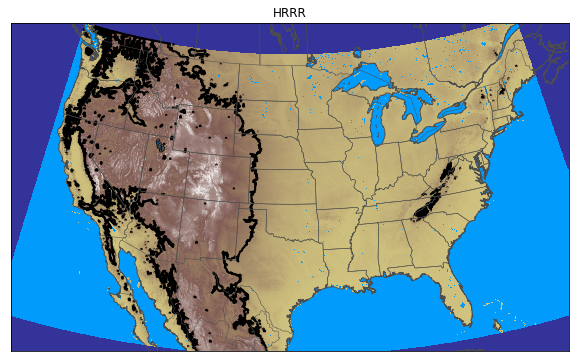

In [274]:
SEGMENTS = {'HRRR':[-125, -67, 24, 50],
            #'west':[-120, -104, 24.4, 50.2],
            #'central': [-104, -88, 24.4, 50.2],
            #'east':[-88, -72, 24.4, 50.2]
           }

for bounds in SEGMENTS.keys():
    # Find segment area
    w, e, s, n = SEGMENTS[bounds]
    sectionA = H['lon']>=w
    sectionB = H['lon']<e
    sectionD = H['lat']>=s
    sectionC = H['lat']<n

    segment = sectionA*sectionB*sectionC*sectionD

    new_H = H['value'].copy()
    new_H[segment==False] = -6100

    plt.figure(figsize=[10,8])
    plt.title(bounds.upper())
    m.pcolormesh(H['lon'], H['lat'], new_H, vmin=-6100, vmax=4183, latlon=True, cmap='terrain');
    m.contour(H['lon'], H['lat'], new_H, levels=[1000], latlon=True, colors='k', linewidths=2);
    m.drawstates(color=[c,c,c]);
    m.drawcountries(color=[c,c,c])
    m.drawcoastlines(color=[c,c,c])
    #m.drawmeridians(np.array([-104-16, -104, -104+16, -104+16+16]), labels=[1,1,0,1], fontsize=10, linewidth=2);
    #m.drawparallels(np.array([24.4, 50.2]), labels=[1,1,1,1], fontsize=10, linewidth=2);

## HRRR Domain Path

In [464]:
PATHS = {'HRRR':{'lon': np.concatenate([H['lon'][0], H['lon'][:,-1], H['lon'][-1][::-1], H['lon'][:,0][::-1]]),
                 'lat': np.concatenate([H['lat'][0], H['lat'][:,-1], H['lat'][-1][::-1], H['lat'][:,0][::-1]])
                },
         'West':{'lon':[-120, -104, -104, -120, -120],
                 'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
         'Central':{'lon':[-104, -88, -88, -104, -104],
                    'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
         'East':{'lon':[-88, -72, -72, -88, -88],
                 'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
        }

PATH_verts = {'HRRR':[(PATHS['HRRR']['lon'][i], PATHS['HRRR']['lat'][i]) for i in range(len(PATHS['HRRR']['lon']))],
              'West':[(PATHS['West']['lon'][i], PATHS['West']['lat'][i]) for i in range(len(PATHS['West']['lon']))],
              'Central':[(PATHS['Central']['lon'][i], PATHS['Central']['lat'][i]) for i in range(len(PATHS['Central']['lon']))],
              'East':[(PATHS['East']['lon'][i], PATHS['East']['lat'][i]) for i in range(len(PATHS['East']['lon']))],
             }

In [466]:
PATH_verts['HRRR']==verts

True

(True, False)

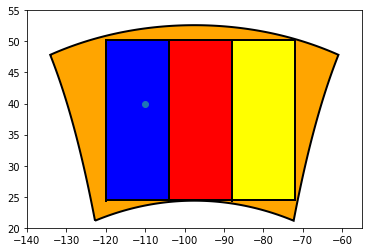

In [476]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

path = Path(PATH_verts['HRRR'])
w_path = Path(PATH_verts['West'])
c_path = Path(PATH_verts['Central'])
e_path = Path(PATH_verts['East'])

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
w_patch = patches.PathPatch(w_path, facecolor='blue', lw=2)
c_patch = patches.PathPatch(c_path, facecolor='red', lw=2)
e_patch = patches.PathPatch(e_path, facecolor='yellow', lw=2)
ax.add_patch(patch)
ax.add_patch(w_patch)
ax.add_patch(c_patch)
ax.add_patch(e_patch)
ax.set_xlim(-140,-55)
ax.set_ylim(20,55)

point = [-110, 40]
ax.scatter(point[0], point[1], zorder=10)
path.contains_point(point), c_path.contains_point(point)

# Load GLM data and filter by path



In [478]:
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

In [701]:
DATE = datetime(2018, 7, 17, 6)
f = get_GLM_file_nearesttime(DATE, window=30)
g = accumulate_GLM_FAST(f)

Looking in these file paths for the nearest datetime
   /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/
   /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/06/
   /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/07/
---------------------------------------------------
    Date Requested: 2018-07-17 06:00:00
  Nearest GLM file: 2018-07-17 06:00:00
---------------------------------------------------
 Window == +/- 30 Minutes
 Window DATES ==  2018-07-17 05:30:00 2018-07-17 06:30:00
    first observation: 2018-07-17 05:30:00
     last observation: 2018-07-17 06:30:00
  Returning data from 180 GLM files (expected 180)
---------------------------------------------------
0.0%
25.0%
20.0%
15.0%
10.0%
5.0%
50.0%
45.0%
40.0%
35.0%
30.0%
75.0%
70.0%
65.0%
60.0%
80.0%
95.0%
90.0%
85.0%


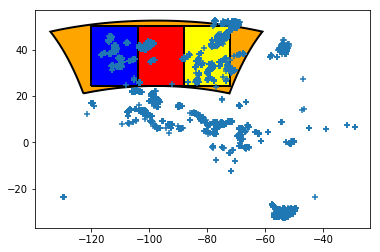

In [669]:
fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
w_patch = patches.PathPatch(w_path, facecolor='blue', lw=2)
c_patch = patches.PathPatch(c_path, facecolor='red', lw=2)
e_patch = patches.PathPatch(e_path, facecolor='yellow', lw=2)
ax.add_patch(patch)
ax.add_patch(w_patch)
ax.add_patch(c_patch)
ax.add_patch(e_patch)

plt.scatter(g['longitude'],g['latitude'], marker='+', zorder=10)

In [548]:
GLM_latlon = [(g['longitude'][i], g['latitude'][i]) for i in range(len(g['latitude']))]
in_hrrr = path.contains_points(GLM_latlon)
in_west = w_path.contains_points(GLM_latlon)
in_central = c_path.contains_points(GLM_latlon)
in_east = e_path.contains_points(GLM_latlon)

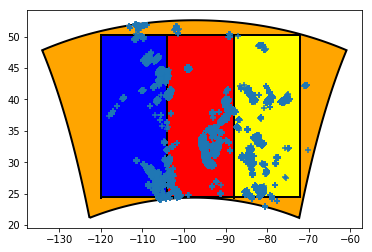

In [549]:
fig = plt.figure()
ax = fig.add_subplot(111)

patch = patches.PathPatch(path, facecolor='orange', lw=2)
w_patch = patches.PathPatch(w_path, facecolor='blue', lw=2)
c_patch = patches.PathPatch(c_path, facecolor='red', lw=2)
e_patch = patches.PathPatch(e_path, facecolor='yellow', lw=2)

ax = plt.gca()
ax.add_patch(patch)
ax.add_patch(w_patch)
ax.add_patch(c_patch)
ax.add_patch(e_patch)

plt.scatter(g['longitude'][in_hrrr],g['latitude'][in_hrrr], marker='+', zorder=10)

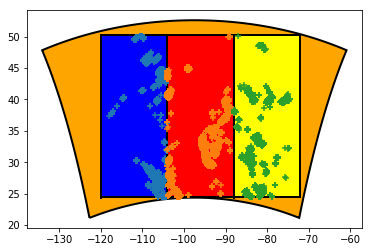

In [551]:
fig = plt.figure()
ax = fig.add_subplot(111)

patch = patches.PathPatch(path, facecolor='orange', lw=2)
w_patch = patches.PathPatch(w_path, facecolor='blue', lw=2)
c_patch = patches.PathPatch(c_path, facecolor='red', lw=2)
e_patch = patches.PathPatch(e_path, facecolor='yellow', lw=2)

ax = plt.gca()
ax.add_patch(patch)
ax.add_patch(w_patch)
ax.add_patch(c_patch)
ax.add_patch(e_patch)

plt.scatter(g['longitude'][in_west],g['latitude'][in_west], marker='+', zorder=10)
plt.scatter(g['longitude'][in_central],g['latitude'][in_central], marker='+', zorder=10)
plt.scatter(g['longitude'][in_east],g['latitude'][in_east], marker='+', zorder=10)

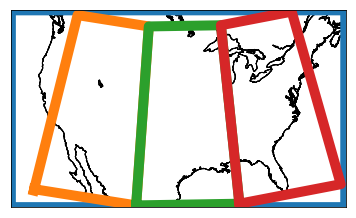

In [539]:
for i in [patch, w_patch, c_patch, e_patch]:
    x = i.get_path().vertices[:,0]
    y = i.get_path().vertices[:,1]
    X, Y = m(x,y)
    m.plot(X,Y, linewidth=10)
    m.drawcoastlines()

In [553]:
Hlon = H['lon']
Hlat = H['lat']

In [658]:
# =============================================================================
# =============================================================================

## Create Path boundaries of HRRR domain and subdomains of interest:
# HRRR: All points counter-clockwise around the model domain.
# West, Central, East: A 16 degree wide and 26 degree tall boundary region.
PATH_points = {
    'HRRR':
        {'lon': np.concatenate([Hlon[0], Hlon[:,-1], Hlon[-1][::-1], Hlon[:,0][::-1]]),
         'lat': np.concatenate([Hlat[0], Hlat[:,-1], Hlat[-1][::-1], Hlat[:,0][::-1]])},
    'West':{
        'lon':[-120, -104, -104, -120, -120],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
    'Central':{
        'lon':[-104, -88, -88, -104, -104],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
    'East':{
        'lon':[-88, -72, -72, -88, -88],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
    'Utah':{
        'lon':[-114.041664, -111.047526, -111.045645,  -109.051460, -109.048632, -114.051534, -114.041664],
        'lat':[41.993580, 42.002846, 40.998538, 40.998403, 36.998310, 37.000574, 41.993580]}
}

## Combine lat/lon as vertice pair as a tuple. i.e. (lon, lat).
PATH_verts = {}
for i in PATH_points.keys():
    PATH_verts[i] = np.array([(PATH_points[i]['lon'][j], PATH_points[i]['lat'][j]) for j in range(len(PATH_points[i]['lon']))])

## Generate Path objects from the vertices.
PATHS = {}
for i in PATH_verts.keys():
    PATHS[i] = Path(PATH_verts[i])

In [660]:
len(PATHS['Utah'])

7

In [670]:
GLM_latlon_pair = [(g['longitude'][i], g['latitude'][i]) for i in range(len(g['latitude']))]

In [671]:
inside_path = {}
for i in PATHS.keys(): 
    inside_path[i] = PATHS[i].contains_points(GLM_latlon_pair)

In [697]:
filtered_glm = {}
for i in inside_path.keys():
    filtered_glm[i] = {'latitude': g['latitude'][inside_path[i]],
                     'longitude': g['longitude'][inside_path[i]],
                     'energy': g['energy'][inside_path[i]],
                     'area': g['area'][inside_path[i]]}

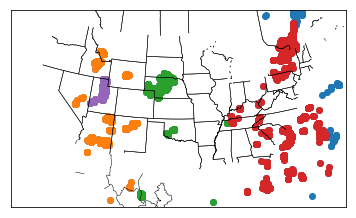

In [698]:
#plt.scatter(g['longitude'], g['latitude'], color='k')
for i in filtered_glm.keys():
    m.scatter(filtered_g[i]['longitude'], filtered_g[i]['latitude'], latlon=True)
m.drawstates()

In [699]:
for i in filtered_glm.keys():
        num = len(filtered_g[i]['latitude'])
        print("Observations in %s region\t:\t%s" % (i, '{:,}'.format(num)))

Observations in HRRR region	:	16,102
Observations in West region	:	2,358
Observations in Central region	:	9,562
Observations in East region	:	3,717
Observations in Utah region	:	1,292


In [704]:
from BB_HRRR.HRRR_Pando import get_hrrr_all_valid
from BB_maps.my_basemap import draw_CONUS_cyl_map

In [702]:
HH = get_hrrr_all_valid(DATE, 'LTNG:entire', fxx=range(19))

In [705]:
mc = draw_CONUS_cyl_map()

In [707]:
CONTOURS = []
for i, H in enumerate(HH):
    c = mc.contour(Hlon, Hlat, H.data, latlon=True, levels=[0])
    CONTOURS.append(c)
plt.close()

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [708]:
CONTOURS

In [778]:
COLLECTION = CONTOURS[1]

for i in paths_glm.keys():
    # Initialize an array to store when points are inside a collection
    # that is the same length as the number of GLM flashes in the domain.
    inside = np.zeros_like(paths_glm[i]['latitude'])
    
    # Combine the lat/lon points into a tuple pair
    latlon_pair = [(paths_glm[i]['longitude'][j], paths_glm[i]['latitude'][j]) for j in range(len(inside))]
    
    # Each collection may have many paths--a path for each contour area.
    # We need to loop through each area and find out which points
    # lie inside the area. Those points that inside the path area (True),
    # Then we add those to the inside array.
    num = len(COLLECTION.collections[level].get_paths())
    for j, V in enumerate(COLLECTION.collections[level].get_paths()):
        is_inside = V.contains_points(latlon_pair)
        inside += is_inside
        sys.stdout.write('\r%s: %.1f%% Complete (%s of %s contour areas)' % (i, (j+1)/num*100, (j+1), num))
    
    # Convert the inside array from a count to a boolean. This boolean
    # matches the lat/lon points in the same order.
    # Add this information to the paths_glm file as a new key 'in_LTNG'
    # meaning the GLM point is inside the HRRR's LTNG field.
    paths_glm[i]['in_LTNG'] = np.array(inside, dtype=bool)

Utah: 100.0% Complete (510 of 510 contour areas)

In [773]:
paths_glm['HRRR']['longitude'][paths_glm['HRRR']['in_LTNG']]

array([ -71.6476  , -100.660225, -100.09911 , ..., -100.0238  ,
       -100.07339 , -100.80042 ], dtype=float32)

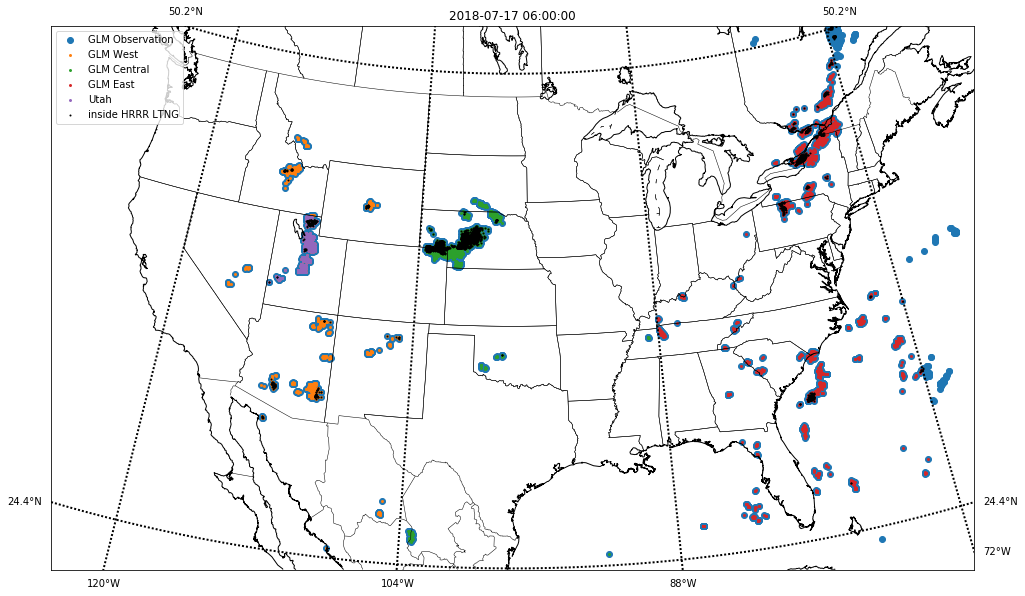

In [786]:
plt.figure(figsize=[20,10])
m.scatter(filtered_glm['HRRR']['longitude'], filtered_glm['HRRR']['latitude'], latlon=True, label='GLM Observation')
m.scatter(filtered_glm['West']['longitude'], filtered_glm['West']['latitude'], latlon=True, marker='.', s=15, label='GLM West')
m.scatter(filtered_glm['Central']['longitude'], filtered_glm['Central']['latitude'], latlon=True, marker='.', s=15, label='GLM Central')
m.scatter(filtered_glm['East']['longitude'], filtered_glm['East']['latitude'], latlon=True, marker='.', s=15, label='GLM East')
m.scatter(filtered_glm['Utah']['longitude'], filtered_glm['Utah']['latitude'], latlon=True, marker='.', s=15, label='Utah')
m.scatter(paths_glm['HRRR']['longitude'][paths_glm['HRRR']['in_LTNG']],
          paths_glm['HRRR']['latitude'][paths_glm['HRRR']['in_LTNG']], latlon=True, s=1, color='k', label='inside HRRR LTNG')

plt.legend()
m.drawstates(); m.drawcoastlines(); m.drawcountries()
m.drawmeridians(np.array([-104-16, -104, -104+16, -104+16+16]), labels=[1,1,0,1], fontsize=10, linewidth=2);
m.drawparallels(np.array([24.4, 50.2]), labels=[1,1,1,1], fontsize=10, linewidth=2);
plt.title(DATE)
plt.savefig('HRRR_GLM_hit-rate_demo')

In [816]:
q1 = {'HRRR':{'lat':0, 'lon':1},
      'West':{'lat':2, 'lon':3}}
q2 = {'HRRR':{'lat':1},
      'West':{'lat':99}}
q3 = {'F02':[1,2,3,4]}
q4 = {'F03':[1,2,3,4]}

In [817]:
qq = {}
for q in [q1, q3, q4]:
  qq.update(q)

In [835]:
DATE

datetime.datetime(2018, 7, 17, 6, 0)

In [819]:
fxx = range(19)

In [821]:
in_LTNG_dicts = [{'HRRR':[1,2,3,4],
                 'West':[5,6,7,8]}]

In [832]:
for i in range(len(in_LTNG_dicts)):
        for d in in_LTNG_dicts[i].keys():
            paths_glm[d]['in_LTNG_F%02d' % i] = in_LTNG_dicts[i][d]
            

In [834]:
paths_glm['West']

{'latitude': array([41.79401 , 39.00792 , 38.440037, ..., 44.06956 , 33.16104 ,
        40.30617 ], dtype=float32),
 'longitude': array([-112.08361 , -112.0622  , -113.36752 , ..., -113.709435,
        -110.29555 , -111.22273 ], dtype=float32),
 'energy': array([2.2736953e-13, 8.6980289e-14, 2.3194744e-13, ..., 4.6847281e-13,
        9.1558197e-15, 1.1139581e-13], dtype=float32),
 'area': array([232.17323, 207.30444, 484.50055, ..., 220.64867,  69.46457,
        150.59145], dtype=float32),
 'in_LTNG': array([False, False, False, ..., False, False, False]),
 'in_LTNG_F0': 'W',
 'in_LTNG_F00': [5, 6, 7, 8]}